# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("final_project_data.csv",index_col=0)
data.index = pd.to_datetime(data.index)
data = data.rename(columns={'GT02': "US_int",
                            'GTGBP2YR':'UK_int',
                            'UKRPCJYR Index':'UK_CPI',
                            'CPI YOY Index':'US_CPI',
                            'IP Index':'US_IP',
                            'UKIPI Index':'UK_IP'})
data.head()

,US_int,UK_int,UK_CPI,US_CPI,US_IP,UK_IP
Date,,,,,,
1989-03-31,9.668,NaN,NaN,NaN,NaN,NaN
1989-04-03,9.528,NaN,NaN,NaN,NaN,NaN
1989-04-04,9.405,NaN,NaN,NaN,NaN,NaN
1989-04-05,9.491,NaN,NaN,NaN,NaN,NaN
1989-04-06,9.526,NaN,NaN,NaN,NaN,NaN


In [3]:
currency_pair = "GBPUSD=X"
ex_rate_data = yf.download(currency_pair)
ex_rate = ex_rate_data[['Open']].copy()
ex_rate = ex_rate.rename(columns={'Open': "GBPUSD"})
ex_rate.head()

[*********************100%***********************]  1 of 1 completed


,GBPUSD
Date,
2003-12-01,1.723811
2003-12-02,1.719010
2003-12-03,1.730493
2003-12-04,1.727414
2003-12-05,1.720608


In [4]:
# Define the date range
start_date = pd.to_datetime('2003-12-01')
end_date = pd.to_datetime('2023-12-29')

# Filter rows based on date range
data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
ex_rate = ex_rate.loc[(ex_rate.index >= start_date) & (ex_rate.index <= end_date)]

In [5]:
# Resample for ex_rate
ex_rate = ex_rate.resample('M').mean()
ex_rate.index = ex_rate.index.map(lambda x: x.replace(day=18))
ex_rate.head()

# Resample for original data
con1_data = data[['US_int','UK_int']].copy()
con1_data = con1_data.resample('M').mean()
con1_data.index = con1_data.index.map(lambda x: x.replace(day=18))
con2_data = data[["US_CPI",'UK_CPI','US_IP','UK_IP']].copy()
con2_data = con2_data.dropna()

In [6]:
merged_df = pd.merge(ex_rate, con1_data, how='inner', left_index=True, right_index=True)
merged_df = pd.merge(merged_df, con2_data, how='inner', left_index=True, right_index=True)

In [7]:
merged_df['int_diff'] =(merged_df['US_int']-merged_df['UK_int'])
merged_df['inf_diff'] =(merged_df['US_CPI']-merged_df['UK_CPI'])
merged_df['ip_diff'] =(merged_df['US_IP']-merged_df['UK_IP'])
merged_df['s_change'] = np.log(merged_df['GBPUSD'].shift(0) / merged_df['GBPUSD'].shift(1))

In [8]:
merged_df

,GBPUSD,US_int,UK_int,US_CPI,UK_CPI,US_IP,UK_IP,int_diff,inf_diff,ip_diff,s_change
Date,,,,,,,,,,,
2003-12-18,1.750379,1.879636,4.381810,1.8,1.3,92.1265,101.8,-2.502173,0.5,-9.6735,NaN
2004-01-18,1.819335,1.723750,4.302095,1.9,1.3,92.1722,101.8,-2.578345,0.6,-9.6278,0.038639
2004-02-18,1.867386,1.708579,4.291800,1.9,1.4,92.3270,103.1,-2.583221,0.5,-10.7730,0.026069
2004-03-18,1.830189,1.552391,4.326478,1.7,1.3,92.8873,102.8,-2.774087,0.4,-9.9127,-0.020120
2004-04-18,1.807011,2.043286,4.539900,1.7,1.1,92.5325,102.9,-2.496614,0.6,-10.3675,-0.012745
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-18,1.271244,4.917217,5.050818,3.2,6.8,103.1900,95.4,-0.133601,-3.6,7.7900,-0.013023
2023-09-18,1.240755,5.045500,4.988143,3.7,6.7,103.2411,95.0,0.057357,-3.0,8.2411,-0.024276
2023-10-18,1.217601,5.083095,4.851818,3.7,6.7,103.3346,94.9,0.231277,-3.0,8.4346,-0.018837


# Forecast of Exchange Rate

## Rolling Window & Holding Period

In [9]:
# Define the range of hyperparameters
rolling_window_sizes = range(5,25)
holding_periods = range(5,25) 

# Initialize an empty DataFrame to store the results
heatmap_data = pd.DataFrame(index=rolling_window_sizes, columns=holding_periods)

# Loop through different combinations of hyperparameters
for window_size in rolling_window_sizes:
    for holding_period in holding_periods:
        for i in range(window_size, len(merged_df)):
            # Extract the data within the rolling window
            window_data = merged_df.iloc[i - window_size:i]
            
            # Fit the model within the rolling window
            forecaster = smf.ols(formula='s_change ~ int_diff + inf_diff + ip_diff', data=window_data).fit()
            
            # Forecast for the next data point
            forecast_value = forecaster.predict(merged_df.iloc[i:i+1])[0]
            
            # Store the forecasted value in the DataFrame
            merged_df.loc[merged_df.index[i], 'forecast'] = forecast_value
        
        # Generate signals and calculate strategy returns
        merged_df['signal'] = np.where(merged_df['forecast'] >= 0, 1, -1)
        merged_df['strategy_return'] = merged_df['signal'] * merged_df['s_change']
        
        # Calculate cumulative return
        cumulative_return = (np.exp(merged_df['strategy_return'].rolling(holding_period).sum()) - 1).iloc[-1] * 100
        
        # Store the cumulative return in the heatmap data
        heatmap_data.at[window_size, holding_period] = cumulative_return


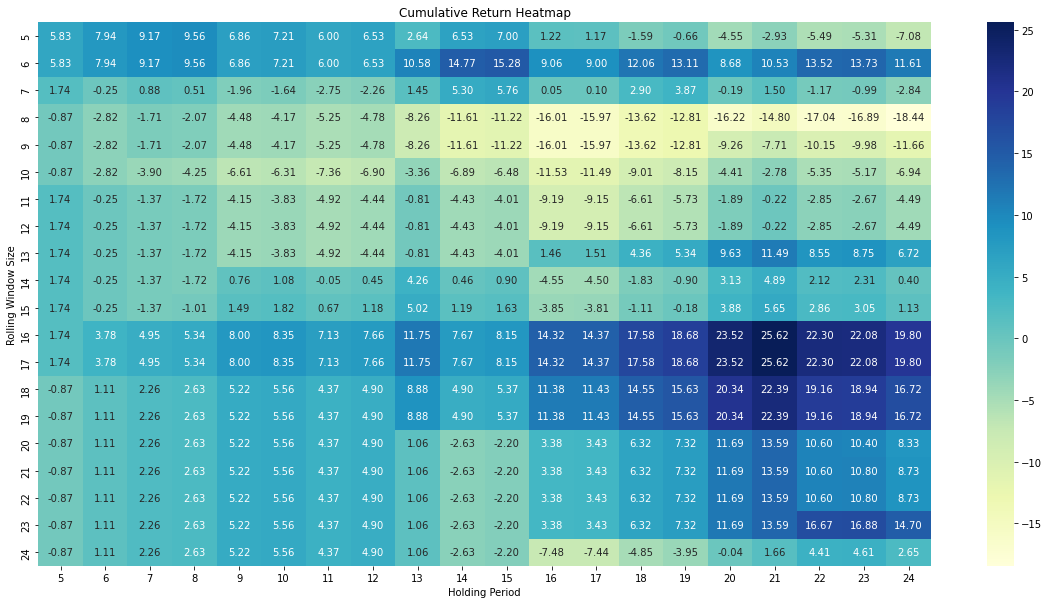

In [10]:
# Visualize the heatmap
heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
plt.title('Cumulative Return Heatmap')
plt.xlabel('Holding Period')
plt.ylabel('Rolling Window Size')
plt.show()

**ANS:** From the heatmap we can tell that the best performance combination are the window size of 16 and the holding period of 21. We will use this conbination to show the performance comparison in below.

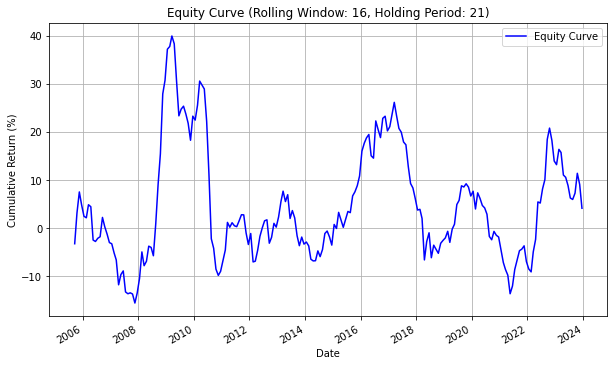

In [15]:
# Best combination of hyperparameters
rolling_window_size = 16
holding_period = 21

# Initialize an empty DataFrame to store the results
equity_curve_df = pd.DataFrame(index=merged_df.index)

# Generate signals and calculate strategy returns using the best combination
merged_df['forecast'] = np.nan
for i in range(rolling_window_size, len(merged_df)):
    # Extract the data within the rolling window
    window_data = merged_df.iloc[i - rolling_window_size:i]
    
    # Fit the model within the rolling window
    forecaster = smf.ols(formula='s_change ~ int_diff + inf_diff + ip_diff', data=window_data).fit()
    
    # Forecast for the next data point
    merged_df['forecast'] = forecaster.predict(merged_df.iloc[i:i+1])[0]
    
    # Store the forecasted value in the DataFrame
    merged_df.loc[merged_df.index[i], 'forecast'] = forecast_value

# Generate signals
merged_df['signal'] = np.where(merged_df['forecast'] >= 0, 1, -1)

# Calculate strategy returns
merged_df['strategy_return'] = merged_df['signal'] * merged_df['s_change']

# Calculate cumulative returns
equity_curve_df['cumulative_return'] = (np.exp(merged_df['strategy_return'].rolling(holding_period).sum()) - 1) * 100

# Plot the equity curve
plt.figure(figsize=(10, 6))
equity_curve_df['cumulative_return'].plot(label='Equity Curve', color='blue')
plt.title('Equity Curve (Rolling Window: 16, Holding Period: 21)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
merged_df.head()

,GBPUSD,US_int,UK_int,US_CPI,UK_CPI,US_IP,UK_IP,int_diff,inf_diff,ip_diff,s_change,forecast,signal,strategy_return,forecast_value
Date,,,,,,,,,,,,,,,
2003-12-18,1.750379,1.879636,4.381810,1.8,1.3,92.1265,101.8,-2.502173,0.5,-9.6735,NaN,-0.029047,-1,NaN,-0.029047
2004-01-18,1.819335,1.723750,4.302095,1.9,1.3,92.1722,101.8,-2.578345,0.6,-9.6278,0.038639,-0.029047,-1,-0.038639,-0.029047
2004-02-18,1.867386,1.708579,4.291800,1.9,1.4,92.3270,103.1,-2.583221,0.5,-10.7730,0.026069,-0.029047,-1,-0.026069,-0.029047
2004-03-18,1.830189,1.552391,4.326478,1.7,1.3,92.8873,102.8,-2.774087,0.4,-9.9127,-0.020120,-0.029047,-1,0.020120,-0.029047
2004-04-18,1.807011,2.043286,4.539900,1.7,1.1,92.5325,102.9,-2.496614,0.6,-10.3675,-0.012745,-0.029047,-1,0.012745,-0.029047


## DMW TEST

In [18]:
P = len(merged_df['forecast'])
MSE_T = ((merged_df['s_change']-merged_df['forecast'])**2).mean()
MSE_R = ((merged_df['s_change']-merged_df['s_change'].shift())**2).mean()

error_R = merged_df['s_change']-merged_df['forecast']
error_T = merged_df['s_change']-merged_df['s_change'].shift()
tmp = np.square(error_R) - np.square(error_T) - (MSE_R - MSE_T)
V_hat = np.sum(np.square(tmp))/P
# Statistic
DMW = abs((MSE_R - MSE_T)/np.sqrt(V_hat/P))
print('Since the DMW statistic is equal to '+ str(DMW)+','+' which is greater than the critical value (1.64),')
print('we reject the null hypothesis that the MP model does not outperform the random walk model.')

Since the DMW statistic is equal to 4.520930797352913, which is greater than the critical value (1.64),
we reject the null hypothesis that the MP model does not outperform the random walk model.


**Optimization Process:** We began by optimizing a trading strategy using two hyperparameters: rolling window size and holding period. We explored 200 combinations of these hyperparameters to find the one that maximizes the cumulative return of the strategy. The best combination in this case is (16,21)

**Code Execution:**
We implemented a rolling window approach to fit a linear regression model and generate forecasts for the next data point.The forecasts were used to generate trading signals based on whether the forecasted value was positive or negative. Strategy returns were calculated by multiplying the signal by the actual change in price.

**DMW Test Result:**
The DMW test resulted in a value of 4.52 which is greater than the critical value (1.64), we reject the null hypothesis that the MP model does not outperform the random walk model.